# Can you help reduce employee turnover?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "bonus" - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

## 💪 Competition challenge

Create a report that covers the following:
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

# Imports

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('whitegrid')

In [82]:
def check_multicollinearity(X):
    # Check for multicollinearity using VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif_data.sort_values(by = "VIF", ascending = False)
    return vif_data

In [5]:
churn = pd.read_csv('./data/employee_churn_data.csv')
churn.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


# Which department has the highest employee turnover? Which one has the lowest?

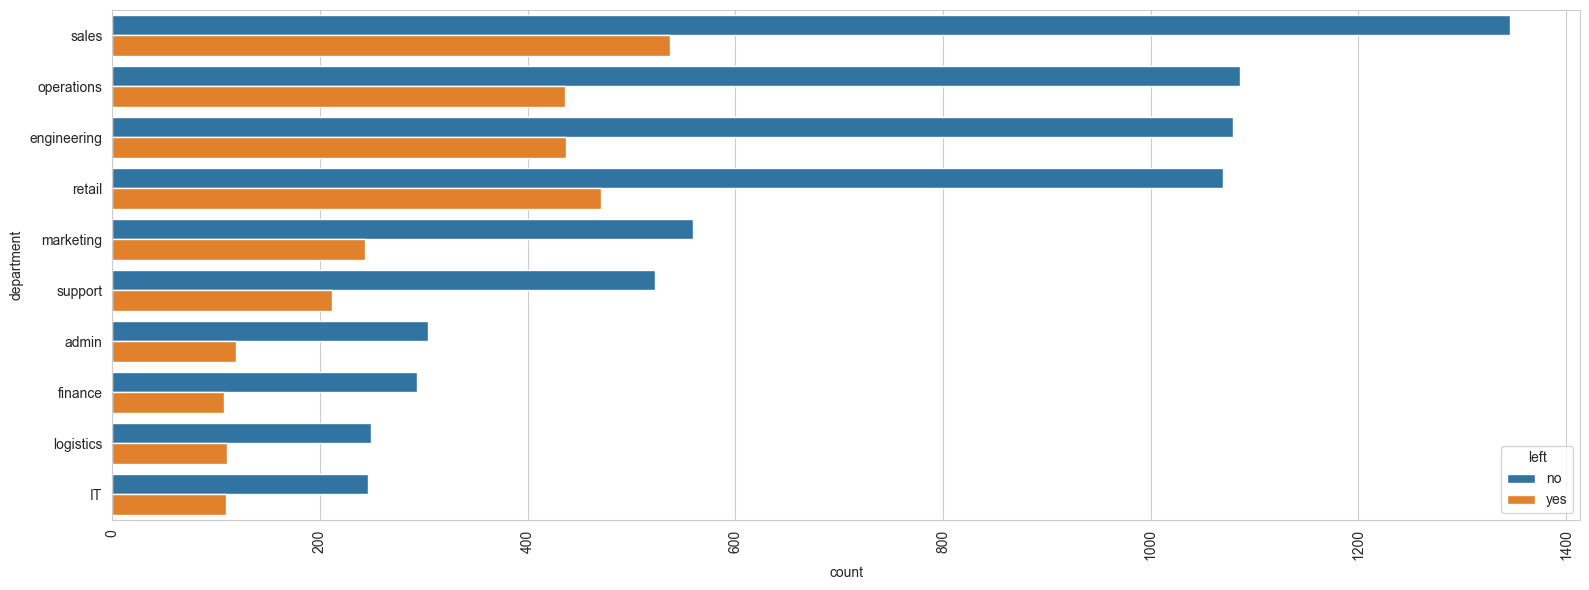

In [71]:
plt.figure(figsize = (16, 6))
df = churn.copy()
df = pd.crosstab(df['department'], df['left']).reset_index()
df = df.melt(id_vars = ['department'])
df.columns = ['department', 'left', 'count']
df = df.sort_values(by = 'count', ascending = False)

sns.barplot(data = df, y = 'department', x = 'count', hue = 'left')
plt.xticks(rotation = 90)
plt.tight_layout()

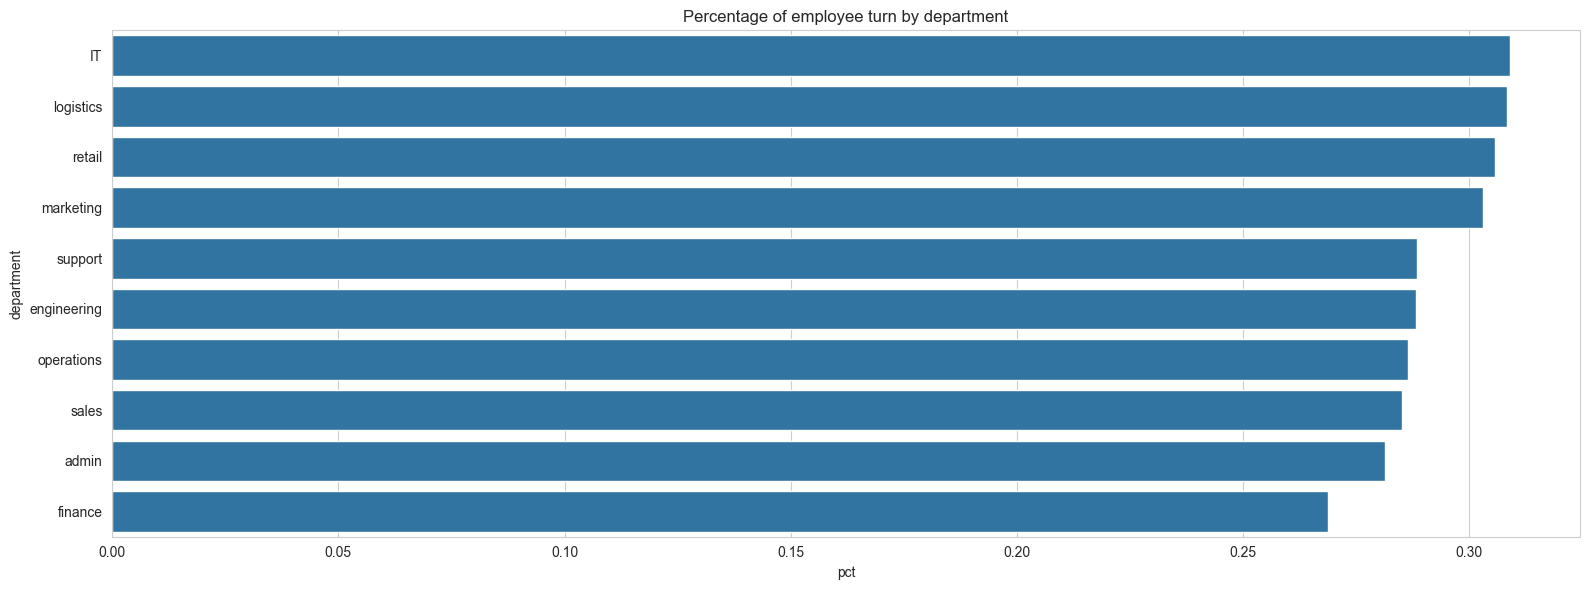

In [72]:
plt.figure(figsize = (16, 6))

df = churn.copy()
df = pd.crosstab(df['department'], df['left'], normalize='index').sort_values(by = 'yes', ascending = False)['yes']
df = df.reset_index()
df.columns = ['department', 'pct']
sns.barplot(data = df, y = 'department', x = 'pct')
plt.title("Percentage of employee turn by department")
plt.tight_layout()

# Investigate which variables seem to be better predictors of employee departure.

## Logistic Regression Model Building

### Initial Model

In [90]:
mapping = {
    'yes': 1,
    'no': 0
}

In [91]:
df = churn.copy()
df['left'] = df['left'].map(mapping)
df = pd.get_dummies(df, drop_first=True)
df

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,left,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support,salary_low,salary_medium
0,0,0.577569,3,5.0,0.626759,0,180.866070,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0.751900,3,6.0,0.443679,0,182.708149,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0.722548,3,6.0,0.446823,0,184.416084,0,0,0,0,0,0,0,0,0,1,0,1
3,0,0.675158,4,8.0,0.440139,0,188.707545,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0.676203,3,5.0,0.577607,1,179.821083,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9535,0,0.610988,4,8.0,0.543641,0,188.155738,1,0,0,0,0,0,1,0,0,0,0,1
9536,0,0.746887,3,8.0,0.549048,0,188.176164,1,0,0,0,1,0,0,0,0,0,0,1
9537,0,0.557980,3,7.0,0.705425,0,186.531008,1,0,0,0,0,0,1,0,0,0,1,0
9538,0,0.584446,4,8.0,0.607287,1,187.641370,1,0,0,0,0,0,0,0,0,0,0,1


In [92]:
X = df.drop('left', axis = 1)
y = df['left']
X = sm.add_constant(X)

check_multicollinearity(X)

,feature,VIF
0,const,38813.647448
1,promoted,1.002160
2,review,1.227687
3,projects,1.001503
4,tenure,23.718474
5,satisfaction,1.204913
6,bonus,1.000621
7,avg_hrs_month,23.847678
8,department_admin,2.092218
9,department_engineering,4.424427


### Drop features

In [95]:
X = df.drop(['left','avg_hrs_month','tenure'], axis = 1)
y = df['left']
X = sm.add_constant(X)

check_multicollinearity(X)

,feature,VIF
0,const,161.362803
1,promoted,1.001862
2,review,1.140226
3,projects,1.000884
4,satisfaction,1.140439
5,bonus,1.000619
6,department_admin,2.091892
7,department_engineering,4.424094
8,department_finance,2.041221
9,department_logistics,1.936414


In [96]:
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547521
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9523
Method:                           MLE   Df Model:                           16
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09317
Time:                        13:27:23   Log-Likelihood:                -5223.3
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                2.152e-218
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3060      0.338    -24.560      0.000      -8.969      -7.643
promoted                  -0.5570      0.156     -3.568      0.000      -0.863      -0.251
review                    10.0737      0.340     29.607      0.000       9.407      10.741
projects                  -0.0544      0.041     -1.318      0.188      -0.135       0.027
satisfaction               2.0079      0.176     11.410      0.000       1.663       2.353
bonus                     -0.0585      0.059     -0.997      0.319      -0.174       0.057
department_admin          -0.1352      0.167     -0.808      0.419      -0.463       0.193
department_engineering    -0.1202      0.136     -0.882      0.378      -0.387       0.147
department_finance        -0.2209      0.170     -1.301      0.193      -0.554       0.112
department_logistics      -0.0410      0.173     -0.237      0.812      -0.379       0.297
department_marketing      -0.0945      0.147     -0.642      0.521      -0.383       0.194
department_operations     -0.1447      0.136     -1.063      0.288      -0.412       0.122
department_retail         -0.0148      0.136     -0.109      0.913      -0.281       0.251
department_sales          -0.1404      0.134     -1.050      0.294      -0.403       0.122
department_support        -0.1105      0.150     -0.739      0.460      -0.404       0.183
salary_low                -0.0233      0.087     -0.268      0.789      -0.193       0.147
salary_medium              0.0468      0.066      0.708      0.479      -0.083       0.176
==========================================================================================
"""

### Dropping insignificant features (Stepwise Reverse)

In [99]:
X = df.drop(['left','avg_hrs_month','tenure','department_retail'], axis = 1)
y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547521
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9524
Method:                           MLE   Df Model:                           15
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09317
Time:                        13:28:23   Log-Likelihood:                -5223.4
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                2.514e-219
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3182      0.319    -26.074      0.000      -8.943      -7.693
promoted                  -0.5571      0.156     -3.569      0.000      -0.863      -0.251
review                    10.0737      0.340     29.607      0.000       9.407      10.741
projects                  -0.0543      0.041     -1.316      0.188      -0.135       0.027
satisfaction               2.0081      0.176     11.412      0.000       1.663       2.353
bonus                     -0.0586      0.059     -0.997      0.319      -0.174       0.057
department_admin          -0.1232      0.126     -0.978      0.328      -0.370       0.124
department_engineering    -0.1082      0.080     -1.349      0.177      -0.265       0.049
department_finance        -0.2089      0.129     -1.617      0.106      -0.462       0.044
department_logistics      -0.0290      0.133     -0.218      0.827      -0.289       0.231
department_marketing      -0.0825      0.097     -0.847      0.397      -0.273       0.108
department_operations     -0.1327      0.080     -1.660      0.097      -0.289       0.024
department_sales          -0.1284      0.076     -1.695      0.090      -0.277       0.020
department_support        -0.0985      0.101     -0.973      0.330      -0.297       0.100
salary_low                -0.0234      0.087     -0.269      0.788      -0.194       0.147
salary_medium              0.0469      0.066      0.709      0.478      -0.083       0.176
==========================================================================================
"""

In [100]:
X = df.drop(['left','avg_hrs_month','tenure','department_retail', 'department_logistics'], axis = 1)
y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547524
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9525
Method:                           MLE   Df Model:                           14
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09317
Time:                        13:28:52   Log-Likelihood:                -5223.4
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                2.885e-220
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3224      0.318    -26.134      0.000      -8.947      -7.698
promoted                  -0.5567      0.156     -3.566      0.000      -0.863      -0.251
review                    10.0731      0.340     29.607      0.000       9.406      10.740
projects                  -0.0544      0.041     -1.317      0.188      -0.135       0.027
satisfaction               2.0085      0.176     11.415      0.000       1.664       2.353
bonus                     -0.0585      0.059     -0.996      0.319      -0.174       0.057
department_admin          -0.1185      0.124     -0.955      0.339      -0.362       0.125
department_engineering    -0.1036      0.077     -1.339      0.181      -0.255       0.048
department_finance        -0.2043      0.127     -1.603      0.109      -0.454       0.045
department_marketing      -0.0778      0.095     -0.819      0.413      -0.264       0.108
department_operations     -0.1281      0.077     -1.661      0.097      -0.279       0.023
department_sales          -0.1238      0.073     -1.701      0.089      -0.266       0.019
department_support        -0.0939      0.099     -0.949      0.343      -0.288       0.100
salary_low                -0.0234      0.087     -0.270      0.787      -0.194       0.147
salary_medium              0.0467      0.066      0.707      0.480      -0.083       0.176
==========================================================================================
"""

In [101]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547528
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9526
Method:                           MLE   Df Model:                           13
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09316
Time:                        13:29:10   Log-Likelihood:                -5223.4
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                3.226e-221
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3325      0.316    -26.344      0.000      -8.952      -7.713
promoted                  -0.5566      0.156     -3.565      0.000      -0.863      -0.251
review                    10.0729      0.340     29.605      0.000       9.406      10.740
projects                  -0.0546      0.041     -1.323      0.186      -0.136       0.026
satisfaction               2.0083      0.176     11.414      0.000       1.663       2.353
bonus                     -0.0586      0.059     -0.997      0.319      -0.174       0.057
department_admin          -0.1182      0.124     -0.952      0.341      -0.361       0.125
department_engineering    -0.1036      0.077     -1.339      0.181      -0.255       0.048
department_finance        -0.2040      0.127     -1.601      0.109      -0.454       0.046
department_marketing      -0.0781      0.095     -0.822      0.411      -0.264       0.108
department_operations     -0.1282      0.077     -1.662      0.097      -0.279       0.023
department_sales          -0.1239      0.073     -1.704      0.088      -0.267       0.019
department_support        -0.0936      0.099     -0.946      0.344      -0.287       0.100
salary_medium              0.0577      0.052      1.111      0.266      -0.044       0.160
==========================================================================================
"""

In [102]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547563
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9527
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09310
Time:                        13:29:50   Log-Likelihood:                -5223.8
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                4.670e-222
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3486      0.316    -26.441      0.000      -8.967      -7.730
promoted                  -0.5596      0.156     -3.585      0.000      -0.866      -0.254
review                    10.0668      0.340     29.598      0.000       9.400      10.733
projects                  -0.0548      0.041     -1.327      0.185      -0.136       0.026
satisfaction               2.0075      0.176     11.410      0.000       1.663       2.352
bonus                     -0.0586      0.059     -0.997      0.319      -0.174       0.057
department_admin          -0.0976      0.122     -0.803      0.422      -0.336       0.141
department_engineering    -0.0830      0.073     -1.133      0.257      -0.227       0.061
department_finance        -0.1833      0.125     -1.467      0.142      -0.428       0.062
department_operations     -0.1075      0.073     -1.473      0.141      -0.251       0.036
department_sales          -0.1033      0.068     -1.512      0.131      -0.237       0.031
department_support        -0.0729      0.096     -0.762      0.446      -0.261       0.115
salary_medium              0.0586      0.052      1.128      0.259      -0.043       0.160
==========================================================================================
"""

In [103]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547594
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9528
Method:                           MLE   Df Model:                           11
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09305
Time:                        13:30:05   Log-Likelihood:                -5224.0
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                6.167e-223
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3641      0.315    -26.540      0.000      -8.982      -7.746
promoted                  -0.5598      0.156     -3.586      0.000      -0.866      -0.254
review                    10.0681      0.340     29.602      0.000       9.401      10.735
projects                  -0.0545      0.041     -1.320      0.187      -0.135       0.026
satisfaction               2.0066      0.176     11.405      0.000       1.662       2.351
bonus                     -0.0581      0.059     -0.989      0.323      -0.173       0.057
department_admin          -0.0835      0.120     -0.695      0.487      -0.319       0.152
department_engineering    -0.0690      0.071     -0.972      0.331      -0.208       0.070
department_finance        -0.1693      0.124     -1.370      0.171      -0.412       0.073
department_operations     -0.0935      0.071     -1.323      0.186      -0.232       0.045
department_sales          -0.0893      0.066     -1.356      0.175      -0.218       0.040
salary_medium              0.0586      0.052      1.129      0.259      -0.043       0.160
==========================================================================================
"""

In [104]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547619
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9529
Method:                           MLE   Df Model:                           10
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09301
Time:                        13:30:19   Log-Likelihood:                -5224.3
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                7.390e-224
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -8.3710      0.315    -26.575      0.000      -8.988      -7.754
promoted                  -0.5614      0.156     -3.595      0.000      -0.867      -0.255
review                    10.0693      0.340     29.606      0.000       9.403      10.736
projects                  -0.0547      0.041     -1.325      0.185      -0.136       0.026
satisfaction               2.0043      0.176     11.395      0.000       1.660       2.349
bonus                     -0.0576      0.059     -0.981      0.326      -0.173       0.057
department_engineering    -0.0607      0.070     -0.867      0.386      -0.198       0.076
department_finance        -0.1611      0.123     -1.309      0.191      -0.402       0.080
department_operations     -0.0852      0.070     -1.223      0.221      -0.222       0.051
department_sales          -0.0810      0.065     -1.250      0.211      -0.208       0.046
salary_medium              0.0581      0.052      1.119      0.263      -0.044       0.160
==========================================================================================
"""

In [107]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin',
    'department_engineering',
    'bonus'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547710
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9531
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09286
Time:                        13:30:59   Log-Likelihood:                -5225.1
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                1.299e-225
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.4022      0.314    -26.744      0.000      -9.018      -7.786
promoted                 -0.5587      0.156     -3.580      0.000      -0.865      -0.253
review                   10.0704      0.340     29.613      0.000       9.404      10.737
projects                 -0.0542      0.041     -1.314      0.189      -0.135       0.027
satisfaction              2.0057      0.176     11.402      0.000       1.661       2.350
department_finance       -0.1457      0.122     -1.197      0.231      -0.384       0.093
department_operations    -0.0691      0.067     -1.027      0.304      -0.201       0.063
department_sales         -0.0648      0.062     -1.042      0.298      -0.187       0.057
salary_medium             0.0581      0.052      1.119      0.263      -0.044       0.160
=========================================================================================
"""

In [108]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin',
    'department_engineering',
    'bonus',
    'department_operations'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547765
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9532
Method:                           MLE   Df Model:                            7
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09277
Time:                        13:31:19   Log-Likelihood:                -5225.7
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                1.718e-226
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.4157      0.314    -26.807      0.000      -9.031      -7.800
promoted              -0.5586      0.156     -3.579      0.000      -0.865      -0.253
review                10.0685      0.340     29.610      0.000       9.402      10.735
projects              -0.0541      0.041     -1.310      0.190      -0.135       0.027
satisfaction           2.0053      0.176     11.401      0.000       1.661       2.350
department_finance    -0.1312      0.121     -1.085      0.278      -0.368       0.106
department_sales      -0.0503      0.061     -0.829      0.407      -0.169       0.069
salary_medium          0.0581      0.052      1.119      0.263      -0.044       0.160
======================================================================================
"""

In [109]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin',
    'department_engineering',
    'bonus',
    'department_operations',
    'department_sales'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547801
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9533
Method:                           MLE   Df Model:                            6
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09271
Time:                        13:31:27   Log-Likelihood:                -5226.0
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                1.740e-227
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.4254      0.314    -26.854      0.000      -9.040      -7.810
promoted              -0.5581      0.156     -3.575      0.000      -0.864      -0.252
review                10.0682      0.340     29.610      0.000       9.402      10.735
projects              -0.0543      0.041     -1.315      0.189      -0.135       0.027
satisfaction           2.0052      0.176     11.401      0.000       1.660       2.350
department_finance    -0.1209      0.120     -1.006      0.315      -0.357       0.115
salary_medium          0.0585      0.052      1.127      0.260      -0.043       0.160
======================================================================================
"""

In [110]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin',
    'department_engineering',
    'bonus',
    'department_operations',
    'department_sales',
    'department_finance'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547855
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9534
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09262
Time:                        13:31:37   Log-Likelihood:                -5226.5
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                1.887e-228
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.4316      0.314    -26.876      0.000      -9.046      -7.817
promoted         -0.5607      0.156     -3.593      0.000      -0.867      -0.255
review           10.0684      0.340     29.611      0.000       9.402      10.735
projects         -0.0544      0.041     -1.318      0.188      -0.135       0.026
satisfaction      2.0076      0.176     11.415      0.000       1.663       2.352
salary_medium     0.0587      0.052      1.131      0.258      -0.043       0.160
=================================================================================
"""

In [111]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin',
    'department_engineering',
    'bonus',
    'department_operations',
    'department_sales',
    'department_finance',
    'salary_medium'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.547922
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9535
Method:                           MLE   Df Model:                            4
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09251
Time:                        13:31:53   Log-Likelihood:                -5227.2
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                2.058e-229
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8.3891      0.311    -26.947      0.000      -8.999      -7.779
promoted        -0.5591      0.156     -3.584      0.000      -0.865      -0.253
review          10.0671      0.340     29.611      0.000       9.401      10.733
projects        -0.0546      0.041     -1.323      0.186      -0.135       0.026
satisfaction     2.0071      0.176     11.414      0.000       1.662       2.352
================================================================================
"""

### Best Model

In [113]:
X = df.drop([
    'left',
    'avg_hrs_month',
    'tenure',
    'department_retail', 
    'department_logistics',
    'salary_low',
    'department_marketing',
    'department_support',
    'department_admin',
    'department_engineering',
    'bonus',
    'department_operations',
    'department_sales',
    'department_finance',
    'salary_medium',
    'projects'
], axis = 1)

y = df['left']
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.548014
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                 9540
Model:                          Logit   Df Residuals:                     9536
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.09236
Time:                        13:32:24   Log-Likelihood:                -5228.1
converged:                       True   LL-Null:                       -5760.0
Covariance Type:            nonrobust   LLR p-value:                2.411e-230
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8.5648      0.282    -30.357      0.000      -9.118      -8.012
promoted        -0.5608      0.156     -3.594      0.000      -0.867      -0.255
review          10.0633      0.340     29.609      0.000       9.397      10.729
satisfaction     2.0066      0.176     11.412      0.000       1.662       2.351
================================================================================
"""

The three variables that are most predictive of employee turnover are **promoted**, **review**, and **satisfaction**

# What recommendations would you make regarding ways to reduce employee turnover?

One of the most impactful ways to reduce employee turnover that the employer can control is to implement policies that improve employee satisfaction. Examples of such strategies include:
- open communication between managers and subordinates
- recognition and rewards (not necessarily promotions but could be if available)
- work-life balance
- professional development
- empowerment and autonomy
- setting clear expectations
- allowing for workplace flexibility